In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/realvoice')

## best epoch 모델 찾기

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from collections import OrderedDict
import gc
import psutil

from feature_multiprocess_gpu_light import get_feature
from data_loader_light import get_dataloader
from net1_light import AudioClassifier

In [4]:
import warnings
warnings.filterwarnings('ignore')

# CONFIG

In [5]:
# 요거만 수정하면 됨
serial = "train_final1"
batch = 16
best_epoch = "train_final1"

In [6]:
with open(f'model_weight/{serial}/config.json') as f:
    config = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'model_weight/train_final1/config.json'

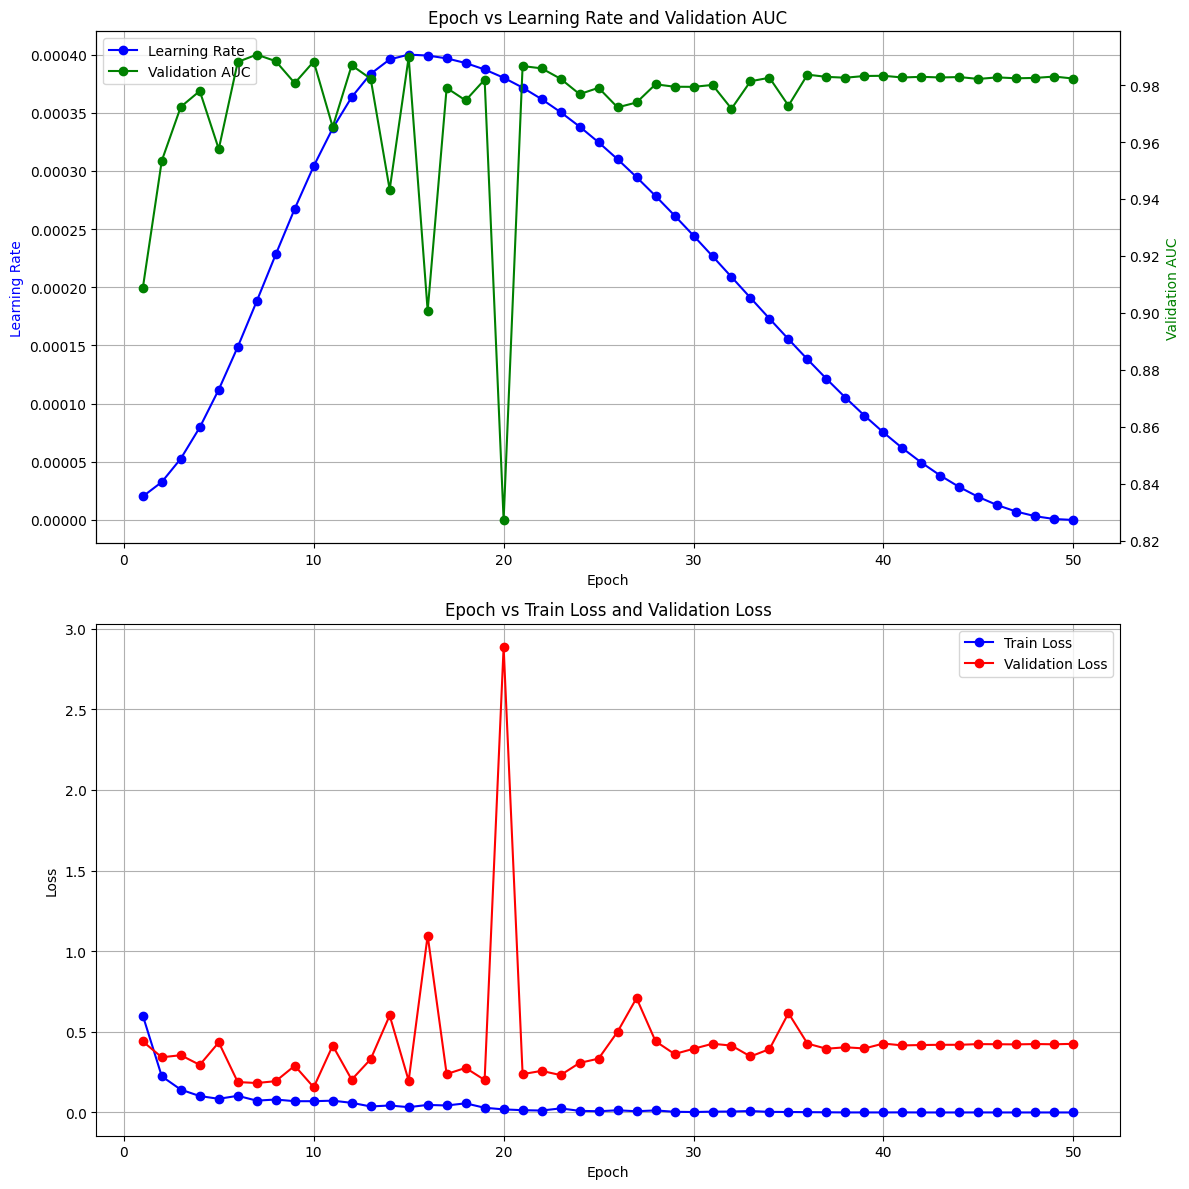

In [ ]:
df = pd.read_csv(config["WEIGHT_DIR"]+f"/{config['SERIAL']}/result.csv")

plt.figure(figsize=(12, 12))

# epoch vs lr 및 epoch vs Val_AUC 시각화 (다른 y축 사용)
ax1 = plt.subplot(2, 1, 1)
ax2 = ax1.twinx()

ax1.plot(df['epoch'], df['lr'], marker='o', label='Learning Rate', color='blue')
ax2.plot(df['epoch'], df['Val_AUC'], marker='o', label='Validation AUC', color='green')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Learning Rate', color='blue')
ax2.set_ylabel('Validation AUC', color='green')
ax1.set_title('Epoch vs Learning Rate and Validation AUC')
ax1.grid(True)

# Legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# epoch vs Train_Loss 및 epoch vs Val_Loss 시각화 (같은 플롯)
plt.subplot(2, 1, 2)
plt.plot(df['epoch'], df['Train_Loss'], marker='o', label='Train Loss', color='blue')
plt.plot(df['epoch'], df['Val_Loss'], marker='o', label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Train Loss and Validation Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## load model

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
weight_path = f'/content/drive/MyDrive/Colab_Notebooks/realvoice/model_weight/{serial}/{best_epoch}.pth'
state_dict = torch.load(weight_path, map_location=device)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "")  # remove `module.`
    new_state_dict[name] = v

model = AudioClassifier(cnn_channel_num=3, rnn_feature_num=67)
model.load_state_dict(new_state_dict)

# 데이터 병렬 처리
if torch.cuda.device_count() > 1:
    print(f"using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model.to(device)
print(f"Using device: {device}")

Using device: cuda


In [8]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for x_cnn, x_len_cnn, x_rnn, x_len_rnn in tqdm(iter(test_loader)):
            x_cnn = x_cnn.float().to(device)
            x_rnn = x_rnn.float().to(device)

            probs = model(x_cnn, x_len_cnn, x_rnn, x_len_rnn)

            probs  = probs.cpu().detach().numpy()
            predictions += probs.tolist()
    return predictions

In [9]:
test_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/realvoice/test.csv")

for index, row in tqdm(test_df.iterrows()):
    path = row['path']
    test_df.at[index, 'path'] = "/content/drive/MyDrive/Colab_Notebooks/realvoice"+path[1:]

test_df.head(3)

50000it [00:03, 14433.80it/s]


,id,path
0,TEST_00000,/content/drive/MyDrive/Colab_Notebooks/realvoi...
1,TEST_00001,/content/drive/MyDrive/Colab_Notebooks/realvoi...
2,TEST_00002,/content/drive/MyDrive/Colab_Notebooks/realvoi...


In [ ]:
n = 100
submit = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/realvoice/sample_submission.csv')
chunk_size = len(test_df)//n
for i in tqdm(range(n), total=n):
    chunk_df = test_df[i*chunk_size:(i+1)*chunk_size]
    test_feature = get_feature(df=chunk_df, train_mode=False)
    test_loader = get_dataloader(dataset=test_feature, batch_size=32, shuffle=False, num_workers=0)
    preds = inference(model, test_loader, device)
    submit.iloc[i*chunk_size:(i+1)*chunk_size, 1:] = preds
    save_path = f'/content/drive/MyDrive/Colab_Notebooks/realvoice/model_weight/{serial}/submit{i}.csv'
    print(f"saving {save_path}")
    submit.to_csv(save_path, index=False)

    # 불필요해진 변수 삭제
    del chunk_df, test_feature, test_loader, preds

    # 가비지 컬렉션 호출
    gc.collect()

  0%|          | 0/100 [00:00<?, ?it/s]

preprocessing feature using 1 number of cpu



100%|██████████| 500/500 [06:13<00:00,  1.34it/s]

100%|██████████| 16/16 [00:14<00:00,  1.07it/s]


saving /content/drive/MyDrive/Colab_Notebooks/realvoice/model_weight/train_final1/submit0.csv


  1%|          | 1/100 [06:29<10:43:00, 389.70s/it]

preprocessing feature using 1 number of cpu



100%|██████████| 500/500 [12:37<00:00,  1.52s/it]

100%|██████████| 16/16 [00:13<00:00,  1.16it/s]


saving /content/drive/MyDrive/Colab_Notebooks/realvoice/model_weight/train_final1/submit1.csv


  2%|▏         | 2/100 [19:21<16:44:04, 614.74s/it]

preprocessing feature using 1 number of cpu



 20%|█▉        | 98/500 [02:30<09:21,  1.40s/it]


In [14]:
gc.collect()

676692